In [4]:
import numpy as np
from matplotlib.lines import Line2D
from expm_mul import expm_multiply
from scipy.sparse.linalg import eigs,norm
from scipy.special import factorial
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
from qutip import qload
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_s(A,b,tol):
    s=1
    if A.dtype==np.complex256:
        s=np.ceil(_exact_1_norm(A))
    else:
        while(1):
            norm_A = _exact_inf_norm(A)/s
#             max_term_notation=np.floor(norm_A)
#             max_term=1
#             for i in range(1,np.int(max_term_notation)):
#                 max_term=max_term*norm_A/i
#                 if max_term >= 10**16:
#                     break
#             if 10**-16 * max_term <= tol:
#                 break
            if 200*1e-16*np.exp(norm_A)<=tol:
                break
            s=s+1
    return s
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)

def gamma_fa(n):
    u = 1.11e-16
    return n*u/(1-n*u)
def beta(norm,m,n):
    beta=gamma_fa(m+1)
    r = 1
    for i in range(1,m):
        r=r*norm/i
        g = gamma_fa(i*(n+2)+m+2)
        beta = beta+g*r
    return beta,r

def taylor_term(i,norm,term):
    return term*norm/i
def error(norm_B,m,s,n,R_m):
    tr = R_m
    rd=beta(norm_B,m,n)[0]
    rd=np.power((1+rd+tr),s)-np.power((1+tr),s)
    tr=tr*s
    tr=tr*((1-np.power(tr,s))/(1-tr))
    return tr+rd
def weaker_error(beta,R_m,s):
    tr = R_m
    rd=beta
    rd = np.power((1 + rd + tr), s) - np.power((1 + tr), s)
    tr = tr * s
    tr = tr * ((1 - np.power(tr, s)) / (1 - tr))
    return tr+rd
def residue_norm(m,norm_B,term):
    R_m=term
    for i in range(m+2,1000):
        term=term*norm_B/i
        R_m=R_m+term
        if term<1e-15:
            break
    return R_m

def choose_ms(norm_A,d,tol):
    no_solution=True
    max_s=int(np.ceil(norm_A))
    if max_s==1:
        max_s=2
    for i in range(1,max_s):
        if no_solution == False:
            break
        norm_B = norm_A / i
        l=int(np.floor(norm_B))
        beta_factor,last_term=beta(norm_B,l,d)
        lower_bound = i*(beta_factor)
        if lower_bound>tol:
            continue
        tr_first_term=norm_B
        m_pass_lowbound=False
        for j in range(1,100):
            if j>l:
                last_term=last_term*norm_B/j
                if last_term<1e-15:
                    break
                beta_factor=beta_factor+gamma_fa(j*(d+2)+2)*last_term
            if m_pass_lowbound == False:
                tr_first_term = tr_first_term * (norm_B / (j + 1))
                if i *tr_first_term + lower_bound > tol:
                    continue
                else:
                    R_m = residue_norm(j, norm_B, tr_first_term)
                    m_pass_lowbound = True
            if m_pass_lowbound == True:
                if weaker_error(beta_factor,R_m,i)>tol:
                    R_m = R_m - tr_first_term
                    tr_first_term = tr_first_term * norm_B / (j + 1)

                    continue
                else:
                    total_error=error(norm_B,j,i,d,R_m)
                    R_m = R_m - tr_first_term
                    tr_first_term = tr_first_term * norm_B / (j + 1)
                    if total_error<tol:
                        no_solution = False
                        s=i
                        m=j
                        break

    if no_solution==False:
        return s,m
    if no_solution == True:
        raise ValueError("please lower the error tolerance ")
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def max_row_number(sparse_matrix):
    row_indice=sparse_matrix.nonzero()[0]
    indice_count=1
    max_count=1
    length=len(row_indice)
    indice = row_indice[0]
    for i in range(1,length):
        if indice==row_indice[i]:
            indice_count=indice_count+1
        else:
            if indice_count>max_count:
                max_count=indice_count
            indice=row_indice[i]
            indice_count=1
    return max_count
def expm_yunwei(A, B,d, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-5
    # if sci.sparse.isspmatrix(A):
    #     d=max_row_number(A)
    # else:
    #     d=len(A)
    norm_A = _exact_inf_norm(A)
    s,m=choose_ms(norm_A,d,tol)
    F=B
    for i in range(int(s)):
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        B = F
    return F,s*m
def overnorm(A):
    if A.dtype==np.complex256:
        return _exact_inf_norm(A)
    else:
        return norm_two(A)
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def norm_two(A):
    if sci.sparse.isspmatrix(A):
        A=csr_matrix(A).conjugate().transpose()
        return np.sqrt(abs(eigs(A=A.dot(A),k=1,which='LM',return_eigenvectors=False)[0]))
    else:
        return np.linalg.norm(A)
def norm_state(A):
    return np.linalg.norm(A)
def block_fre(A,E):
    if isspmatrix(A) is False:
        A = np.block([[A, E], [np.zeros_like(A), A]])
    else:
        A = bmat([[A, E], [None, A]]).tocsc()
    return A
def difference(A,B):
    return overnorm(A-B)/overnorm(A)
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec
def get_auxiliary(dim,tp,t):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(2*HILBERT_SIZE*Q_dim)
    vec[0:HILBERT_SIZE*Q_dim]=0
    A=block_fre(t*H,-1j*(B+B_dag))
    return A,vec
def get_norm(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=400
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=ts[i]*csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        anorm.append(norm_two(H))
    return anorm
def get_norm_der(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        A=ts[i]*block_fre(H,-1j*(A+A_dag))
        anorm.append(norm_two(A))
    return anorm

In [5]:
reference = qload('reference')
theta_m=np.array([[8.70950435e-01, 2.48853043e+00, 4.02062662e+00, 5.51075280e+00,
        6.97775212e+00, 8.43027209e+00, 9.87290220e+00, 1.13089234e+01,
        1.27393366e+01, 1.41653119e+01, 1.55887688e+01],
       [1.79283319e-01, 1.30547755e+00, 2.68990434e+00, 4.11674468e+00,
        5.55078449e+00, 6.98409736e+00, 8.41474411e+00, 9.84240944e+00,
        1.12672525e+01, 1.26895571e+01, 1.41096178e+01],
       [0.13,1, 2.2, 3.6,
        4.9, 6.3, 7.7, 9.1,
        11, 12, 13],
       [5.87845778e-03, 3.11153531e-01, 1.11496247e+00, 2.19235380e+00,
        3.40348589e+00, 4.68492721e+00, 6.00642014e+00, 7.35228229e+00,
        8.71376145e+00, 1.00856663e+01, 1.14647607e+01],
        [0.003307471010225917,0.24259255239783006,0.9560279579613657,1.9645322216064995,3.1267463661459876,4.372820117778894,5.667919829026178,6.993478543263042,8.338922480962493,9.697877908033124,11.066316441049558 ],
       [2.3e-03, 0.14, 0.64, 1.4,
        2.4, 3.5, 4.7, 6,
        7.2, 8.5, 9.9]])
theta_mm=[]
for j,_theta in enumerate(theta_m):
    a={5:0,10:0,15:0,20:0,25:0,30:0,35:0,40:0,45:0,50:0,55:0}
    for i, theta in enumerate(_theta):
        a[5*(i+1)] = theta
    theta_mm.append(a)

Loaded dict object.


Text(27.09375, 0.5, 'time cost ratio: our method / scipy')

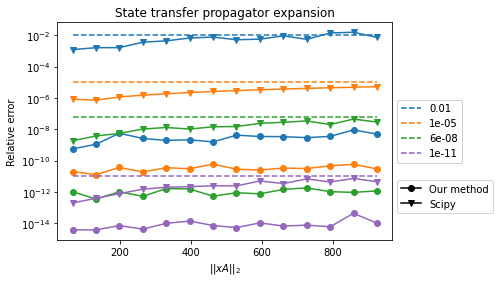

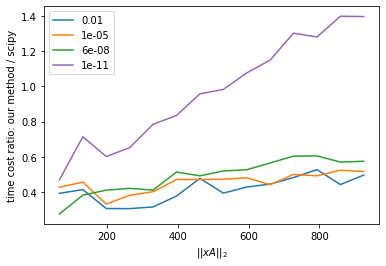

In [70]:
ref = reference['state_propagator']
tols=np.array([1e-2,1e-5,2**-24,1e-11])
dim=20
ts = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))

for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st = (np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)
        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st=(np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=expm_yunwei(t*H, vec,5, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))


norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-11])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Our method',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator expansion')
fig.savefig('State_propagator_0.pdf',bbox_inches='tight')

# fig,ax = plt.subplots()
# color = ['r','b']
# color=['tab:blue','tab:orange','tab:green','tab:purple','k']
# i=2
# ax.plot(norm,new_error[i],color = color[i],marker='o' )
# ax.plot(norm,new_error1[i],color = color[i],marker='v'  )
# ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color=color[i])
# i=4
# ax.plot(norm,new_error[i],color = color[i],marker='o')
# ax.plot(norm,new_error1[i],color = color[i],marker='v')
# ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color=color[i])
# ax.annotate('Scipy',
#       xy     = (     norm[9], new_error1[i][9]),
#       xytext = (0.8*norm[9], 1.25*new_error1[i][9]),
#       color  = color[i],fontsize=15)
# ax.annotate('Our method',
#       xy     = (     norm[9], new_error[i][9]),
#       xytext = (0.7*norm[9], 2*new_error[i][9]),
#       color  = color[i],fontsize=15)
# ax.annotate('tol=1.1 x $10^{-16}$',
#       xy     = (     norm[9], tols[i]),
#       xytext = (0.7*norm[9], 1.25*tols[i]),
#       color  = color[i],fontsize=15)
# ax.annotate('tol=6x$10^{-8}$',
#       xy     = (     norm[0], tols[2]),
#       xytext = (norm[0], 0.15*tols[2]),
#       color  = color[2],fontsize=15)
# ax.set_yscale('log')
# ax.set_xlabel('$||xA||_2$')
# ax.set_ylabel('Relative error')
# ax.set_title('State transfer propagator expansion')
# fig.savefig('State_propagator_1.pdf',bbox_inches='tight')
ts = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
norm = get_norm(ts)
import numpy as np
yunwei_time=np.array([1.16,1.5, 1.96, 2.27, 2.59, 3.17, 4.33, 3.94, 4.41, 4.76, 5.84, 6.45, 6.12, 6.71, 1.2, 1.59, 2.09, 2.63, 3.07, 3.94, 4.41, 4.73, 5.33, 5.48, 6.42, 6.57, 7.37, 7.79, 1.29, 2.15, 2.67, 3.27, 3.78, 4.74, 5.23, 5.8, 6.53, 7.49, 8.22, 9.04, 9.39, 10.17, 1.76, 2.89, 4.31, 5.69, 7.25, 8.77, 10.63, 12.71, 14.48, 17.03, 19.43, 20.74, 23.87, 25.61])
yunwei_time=yunwei_time.reshape([4,14])
sci_time = np.array([2.96, 3.63, 6.41, 7.44, 8.23, 8.42, 9.08, 10.02, 10.31, 10.71, 12.12, 12.24, 13.85, 13.53, 2.81, 3.49, 6.32, 6.9, 7.65, 8.37, 9.37, 10.02, 11.09, 12.43, 12.85, 13.37, 14.09, 15.1, 4.69, 5.63, 6.51, 7.78, 9.21, 9.24, 10.64, 11.17, 12.41, 13.27, 13.62, 14.95, 16.48, 17.71, 3.76, 4.05, 7.17, 8.73, 9.24, 10.51, 11.1, 12.94, 13.45, 14.82, 14.92, 16.2, 17.07, 18.34]
)
sci_time=sci_time.reshape([4,14])
ratios=yunwei_time/sci_time
import matplotlib.pyplot as plt
tols=[1e-2,1e-5,6e-8,1e-11,1.1e-16]
ratios_pre = yunwei_ms/sci_ms*(1/3)
fig,ax = plt.subplots()

for i,ratio in enumerate(ratios):
    ax.plot(norm,ratio,label=tols[i],color=color[i])
#     ax.plot(norm,ratios_pre[i],'--',color=color[i])
ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('time ratio')
ax.legend()
fig.savefig('runtime_pre.pdf')
# fig,ax = plt.subplots()
# ax.plot(norm,ratios[2],color=color[2])
# ax.plot(norm,ratios[4],color=color[4])
# ax.annotate('tol=6x$10^{-8}$',
#       xy     = (     0.8*norm[9], ratios[2][9]),
#       xytext = (0.7*norm[9], 1.3*ratios[2][9]),
#       color  = color[2],fontsize=15)
# ax.annotate('tol=1.1 x $10^{-16}$',
#       xy     = (     norm[9], ratios[4][9]),
#       xytext = (0.7*norm[9], 0.8*ratios[4][9]),
#       color  = color[4],fontsize=15)
# ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('time cost ratio: our method / scipy')
#fig.savefig('runtime_pre.pdf')


IndexError: index 4 is out of bounds for axis 0 with size 4

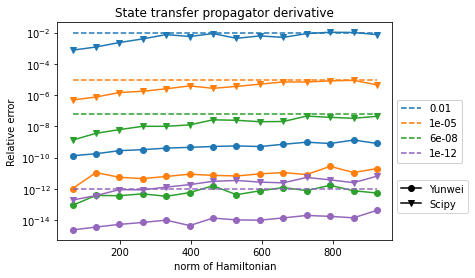

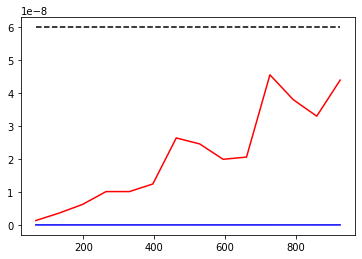

In [98]:
tols=np.array([1e-2,1e-5,2**-24,1e-11])
dim=20
ts = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference["state_propagator_der"]
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,1)
    H_st,vec=get_auxiliary(dim,np.float128,1)
    
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(240)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)
        new_error1[j][i]=(norm_two(sas-sas_st))/norm_two(sas_st)
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,1)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(240)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=expm_yunwei(t*H, vec,5, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_0.pdf',bbox_inches='tight')
fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_1.pdf',bbox_inches='tight')
import numpy as np
color=['tab:blue','tab:orange','tab:green','tab:purple','k']
yunwei_time=np.array([1.428, 1.8830000000000002, 2.336, 2.7359999999999998, 3.164, 3.646, 4.017999999999999, 4.397, 4.892, 5.254, 1.496, 1.9920000000000002, 2.446, 2.9720000000000004, 3.4309999999999996, 3.9419999999999993, 4.401000000000001, 4.8950000000000005, 5.289, 5.784000000000001, 1.548, 2.139, 2.63, 3.168, 3.7079999999999997, 4.232000000000001, 4.753, 5.287000000000001, 5.864, 6.348000000000001, 1.777, 2.6580000000000004, 3.382, 4.117, 4.86, 5.67, 6.447, 7.270999999999999, 7.9879999999999995, 8.63, 3.215, 5.585, 7.925, 10.139000000000001, 12.401, 14.895000000000001, 16.948, 19.427999999999997, 21.669999999999998, 24.072999999999997])
yunwei_time=yunwei_time.reshape([5,10])
sci_time = np.array([2.034, 2.9559999999999995, 7.026999999999999, 8.008000000000001, 9.142, 9.913, 11.251999999999999, 11.812999999999999, 12.708000000000002, 13.541, 2.3280000000000003, 3.528, 7.589999999999999, 8.564999999999998, 9.848000000000003, 10.805, 11.987, 13.075, 14.191999999999998, 15.234, 5.454, 6.645999999999999, 7.986999999999999, 9.382000000000001, 10.736999999999998, 11.758999999999999, 13.154, 14.666, 16.069, 16.923, 2.8409999999999997, 7.314, 8.728, 10.532999999999998, 11.843, 13.413, 14.956000000000003, 16.569, 18.041, 19.45, 3.134, 7.781000000000001, 9.561000000000002, 11.155, 13.074000000000002, 14.857, 16.497999999999998, 18.195999999999998, 19.938, 21.6])
sci_time=sci_time.reshape([5,10])
ratios=yunwei_time/sci_time
import matplotlib.pyplot as plt
tols=[1e-2,1e-5,6e-8,1e-12,1.1e-16]
ratios_pre = yunwei_ms/sci_ms*(1/3)
fig,ax = plt.subplots()

for i,ratio in enumerate(ratios):
    ax.plot(norm,ratio,label=tols[i],color=color[i])
    ax.plot(norm,ratios_pre[i],'--',color=color[i])
ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('time ratio')
ax.legend()

In [13]:
from qutip import qload
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix,identity
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat,kron
import scipy as sci
from scipy.sparse import csr_matrix,isspmatrix,bmat
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_norm(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        anorm.append(overnorm(dim[i]*H))
    return anorm
def get_norm_der(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        vec=1/np.sqrt(2*2**N)*np.identity(2*2**N)
        A=block_fre(H,-1j*(control[0]))
        anorm.append(overnorm(dim[i]*A))
    return anorm
def get_auxiliary(N,tp,t):
    control=get_control(N,tp)
    H,vec = get_H(N,tp)
    vec=1/np.sqrt(2**N)*np.ones(2*2**N)
    vec[0:2**N]=0
    A=block_fre(t*H,-1j*(control[3]))
    return A,vec
def get_int(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmaz=sigmap.dot(sigmam)
    H0=0
    SIGMAZ=kron(sigmaz,sigmaz)
    H0=H0+kron(SIGMAZ,identity(2**(N-2)))+kron(identity(2**(N-2)),SIGMAZ)
    for i in range(1,N-2):
        H0=H0+kron(kron(identity(2**i),SIGMAZ),identity(2 ** (N - 2 - i)))
    return H0
def get_control(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmap=sigmap
    sigmam=sigmam
    sigmax=sigmap+sigmam
    sigmay=-1j*sigmap+1j*sigmam
    control=[]
    if N==1:
        control.append(kron(sigmax, identity(2 ** (N - 1))))
        control.append(kron(sigmay, identity(2 ** (N - 1))))
        return control
    else:
        a=identity(2**(N-1))
        control.append(kron(sigmax,a,format="csc"))
        control.append(kron(sigmay, identity(2 ** (N - 1)),format="csc"))
        for i in range(1,N-1):
            control.append(kron(kron(identity(2**i),sigmax), identity(2 ** (N - 1-i)),format="csc"))
            control.append(kron(kron(identity(2 ** i), sigmay), identity(2 ** (N - 1 - i)),format="csc"))
        control.append(kron(identity(2**(N-1)),sigmax,format="csc"))
        control.append(kron(identity(2**(N-1)),sigmay,format="csc"))
    return control
def control_H(control,H_control):
    H=0
    for i in range(len(control)):
        H=H+control[i]*H_control[i]
    return H
def get_H(N,tp):
    control=get_control(N,tp)
    control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
    H_control=control_H(control_pra,control)
    H=-1j*(H_control+get_int(N,tp)*0.1*2*np.pi)
    vec=1/np.sqrt(2**N)*np.ones(2**N)
    return H,vec


IndexError: index 4 is out of bounds for axis 0 with size 4

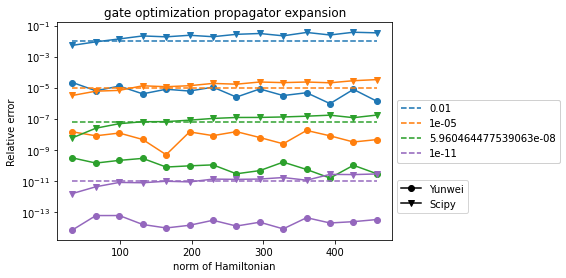

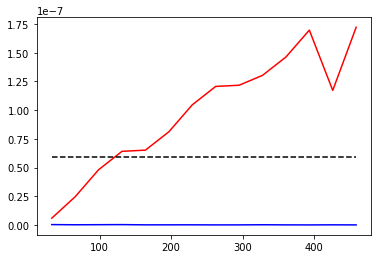

In [16]:
dim=7
tols=np.array([1e-2,1e-5,2**-24,1e-11])
ts = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference['gate_propagator']
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(128)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(128)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=expm_yunwei(t*H, vec,8, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']


legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_1.pdf',bbox_inches='tight')
import numpy as np
color=['tab:blue','tab:orange','tab:green','tab:purple','k']
yunwei_time=np.array([2.146, 2.5200000000000005, 2.8779999999999997, 3.242, 3.5989999999999993, 3.978, 4.305000000000001, 4.661999999999999, 5.052, 5.403, 1.9939999999999998, 2.487, 2.9210000000000003, 3.344, 3.724, 4.145999999999999, 4.501000000000001, 4.932, 5.3389999999999995, 5.729, 2.056, 2.52, 2.971, 3.428, 3.864, 4.327, 4.733999999999999, 5.180999999999999, 5.635999999999999, 6.090999999999999, 2.1630000000000003, 2.8240000000000003, 3.3989999999999996, 4.038000000000001, 4.613, 5.295, 5.859999999999999, 6.484, 7.106, 7.661, 3.151, 4.878, 6.628, 8.327, 10.046000000000001, 11.753, 13.678, 15.159, 16.976999999999997, 18.872])
yunwei_time=yunwei_time.reshape([5,10])
sci_time = np.array([2.5010000000000003, 3.55, 7.389999999999999, 8.652, 9.412, 10.652, 11.461, 12.639000000000001, 13.597, 14.672999999999998, 2.8400000000000003, 3.8620000000000005, 7.769, 9.196000000000002, 10.350000000000001, 11.396, 12.531, 14.264, 15.212, 16.349, 5.528999999999999, 6.944, 8.367, 9.832, 11.166999999999998, 12.632, 14.071000000000002, 15.352, 16.901, 18.262999999999998, 3.071, 4.718, 9.132, 11.134, 12.896, 14.108, 15.751000000000001, 17.375000000000004, 19.144, 20.737000000000002, 3.7030000000000003, 5.42, 9.762, 11.713000000000001, 13.612, 15.475999999999999, 17.354999999999997, 19.276000000000003, 21.177, 23.033])
sci_time=sci_time.reshape([5,10])
ratios=yunwei_time/sci_time
import matplotlib.pyplot as plt
tols=[1e-2,1e-5,6e-8,1e-12,1.1e-16]
ratios_pre = yunwei_ms/sci_ms*(1/3)
fig,ax = plt.subplots()

for i,ratio in enumerate(ratios):
    ax.plot(norm,ratio,label=tols[i],color=color[i])
    ax.plot(norm,ratios_pre[i],'--',color=color[i])
ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('time ratio')
ax.legend()

IndexError: index 4 is out of bounds for axis 0 with size 4

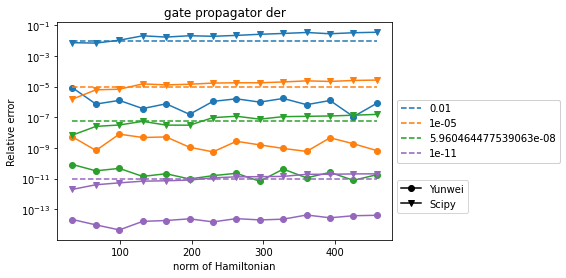

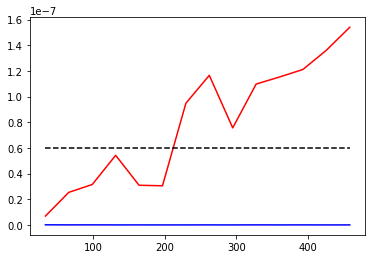

In [15]:
dim=7
tols=np.array([1e-2,1e-5,2**-24,1e-11])
ts = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference['gate_propagator_der']
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,1)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(256)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,1)

    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(256)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=expm_yunwei(t*H, vec,9, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
        
norm = get_norm(ts)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_1.pdf',bbox_inches='tight')
color=['tab:blue','tab:orange','tab:green','tab:purple','k']
yunwei_time=np.array([2.0840000000000005, 2.645, 3.1919999999999997, 3.696, 4.181, 4.671, 5.215, 5.729, 6.162, 6.674000000000001, 2.151, 2.7889999999999997, 3.3339999999999996, 3.874, 4.438000000000001, 4.96, 5.473999999999999, 6.042, 6.606999999999999, 7.206, 2.2339999999999995, 2.84, 3.467, 4.086, 4.606999999999999, 5.228, 5.781000000000001, 6.409000000000001, 6.991999999999999, 7.616, 2.427, 3.268, 4.0600000000000005, 4.9, 5.66, 6.590000000000001, 7.367, 8.126999999999999, 8.924, 9.719, 3.7489999999999997, 6.156999999999999, 8.386999999999999, 10.732, 13.103, 15.498999999999999, 17.726999999999997, 20.026, 22.351000000000003, 24.705999999999996])
yunwei_time=yunwei_time.reshape([5,10])
sci_time = np.array([2.8550000000000004, 3.8880000000000003, 8.503, 10.028, 10.886, 12.049, 13.331999999999999, 14.654, 15.761000000000001, 16.916999999999998, 2.8720000000000003, 4.208, 9.004, 10.664, 11.999999999999998, 13.169, 14.898999999999997, 16.438, 17.723999999999997, 18.97, 6.445, 8.042, 9.648, 11.305000000000001, 12.988999999999999, 14.654999999999998, 16.160000000000004, 17.864, 19.496, 21.224000000000004, 3.7739999999999996, 5.464, 10.690999999999999, 12.837, 14.503, 16.331000000000003, 18.146000000000004, 20.291999999999994, 22.024, 23.95, 4.0649999999999995, 5.984, 11.349, 13.534, 15.755, 17.886999999999997, 20.078, 22.316000000000003, 24.535, 26.791000000000004])
sci_time=sci_time.reshape([5,10])
ratios=yunwei_time/sci_time
import matplotlib.pyplot as plt
tols=[1e-2,1e-5,6e-8,1e-12,1.1e-16]
ratios_pre = yunwei_ms/sci_ms*(1/3)
fig,ax = plt.subplots()

for i,ratio in enumerate(ratios):
    ax.plot(norm,ratio,label=tols[i],color=color[i])
    ax.plot(norm,ratios_pre[i],'--',color=color[i])
ax.set_xlabel('$||xA||_2$')
ax.set_ylabel('time ratio')
ax.legend()